In [52]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [53]:

# Load your training dataset
file_path = '../dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


In [54]:
def text_preprocessing(text):
    # Lowercase all sentences
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'[-+]?[0-9]+', ' ', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    
    # Remove punctuation and other symbols
    text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)

    # Correct duplication of three or more characters in a row (e.g., "yukkk" -> "yuk")
    text = re.sub(r'([a-zA-Z])\1\1+', r'\1', text)
    
    # Remove multiple whitespace
    text = re.sub(r' +', ' ', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize words
    word_tokens = word_tokenize(text)
    
    # Define English stopwords removal
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in word_tokens if word not in stop_words]
    
    # Join tokens back into a clean string
    clean_words = ' '.join(clean_words)
    
    return clean_words


In [55]:

# Lemmatization function
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the training dataset
train_texts = train_data['CONTENT'].apply(text_preprocessing).apply(lemmatize_text)
train_labels = train_data['CLASS']

# Convert the text data into TF-IDF feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_texts)


In [56]:

# Define models for training, including SVM with different kernels
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2),
    'NaiveBayes': MultinomialNB(alpha=0.5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1),
    'SVM_Linear': SVC(kernel='linear', probability=True, C=1),
    'SVM_RBF': SVC(kernel='rbf', probability=True, C=1, gamma='scale'),
    'SVM_Poly': SVC(kernel='poly', probability=True, C=1, degree=3),
    'SVM_Sigmoid': SVC(kernel='sigmoid', probability=True, C=1)
}



Training and Cross-Validating RandomForest...
Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.89
Confusion Matrix:
[[923  28]
 [195 810]]


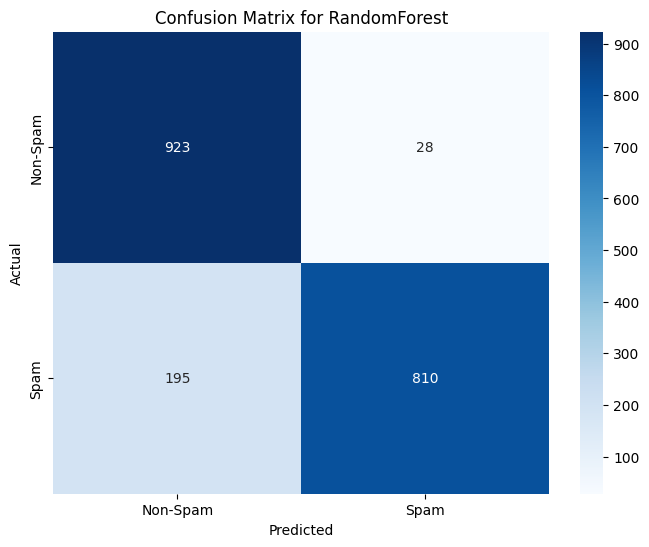


Training and Cross-Validating NaiveBayes...
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1 Score: 0.89
Confusion Matrix:
[[862  89]
 [119 886]]


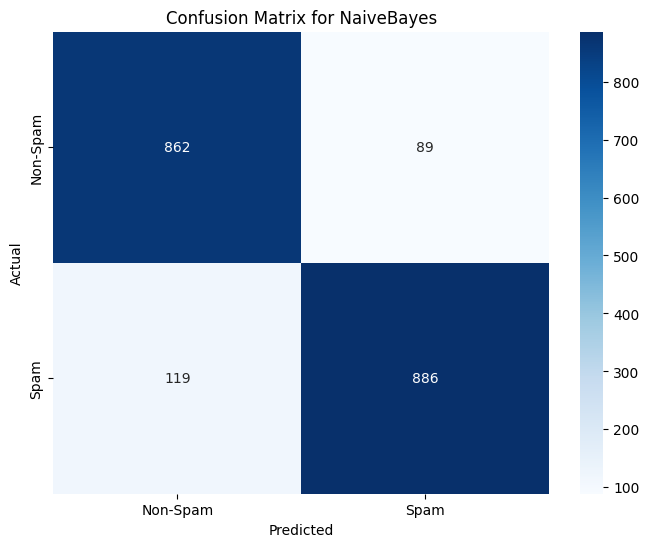


Training and Cross-Validating XGBoost...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[924  27]
 [161 844]]


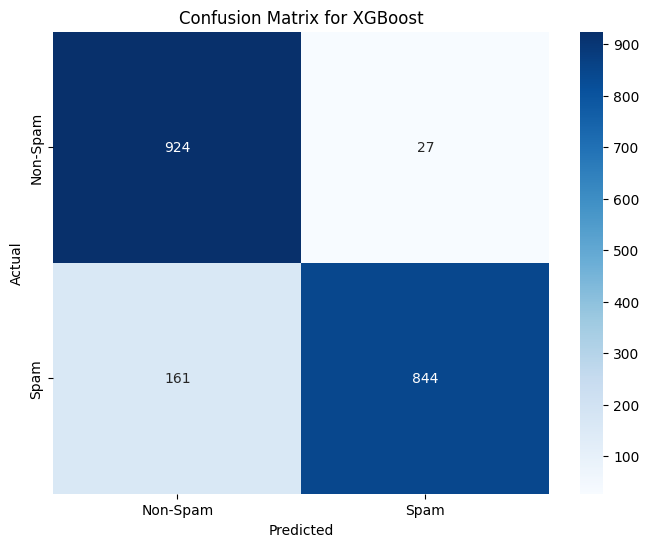


Training and Cross-Validating SVM_Linear...
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Confusion Matrix:
[[905  46]
 [134 871]]


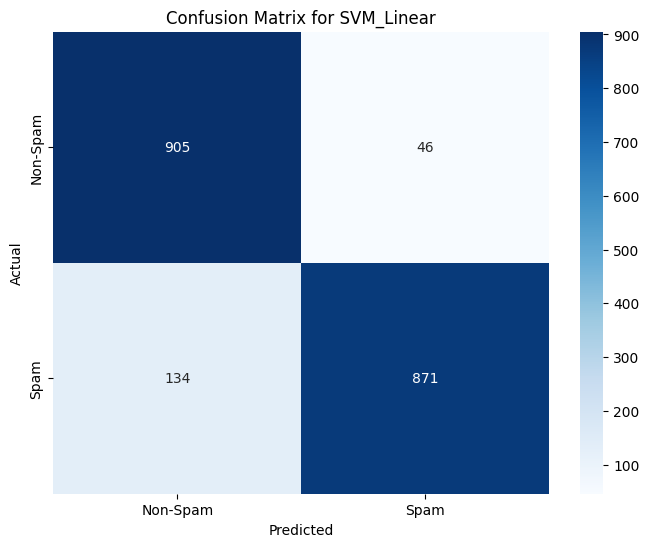


Training and Cross-Validating SVM_RBF...
Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1 Score: 0.91
Confusion Matrix:
[[906  45]
 [126 879]]


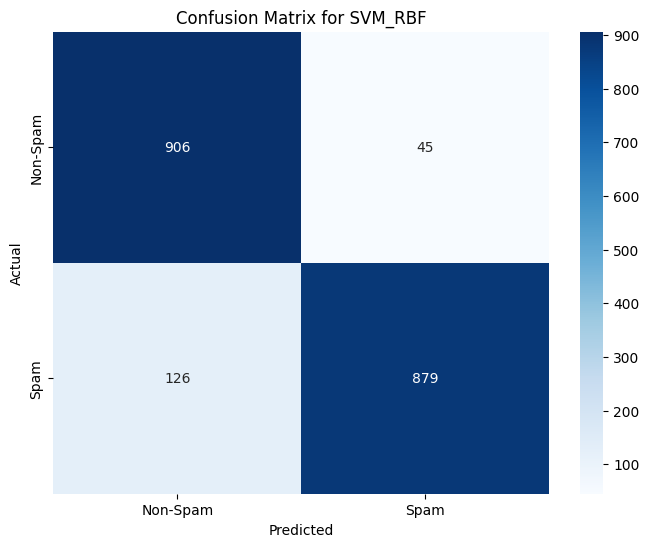


Training and Cross-Validating SVM_Poly...
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[766 185]
 [ 70 935]]


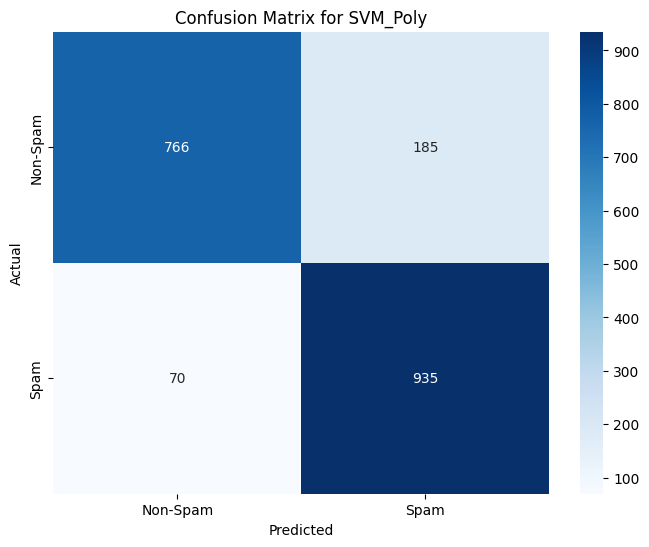


Training and Cross-Validating SVM_Sigmoid...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[900  51]
 [147 858]]


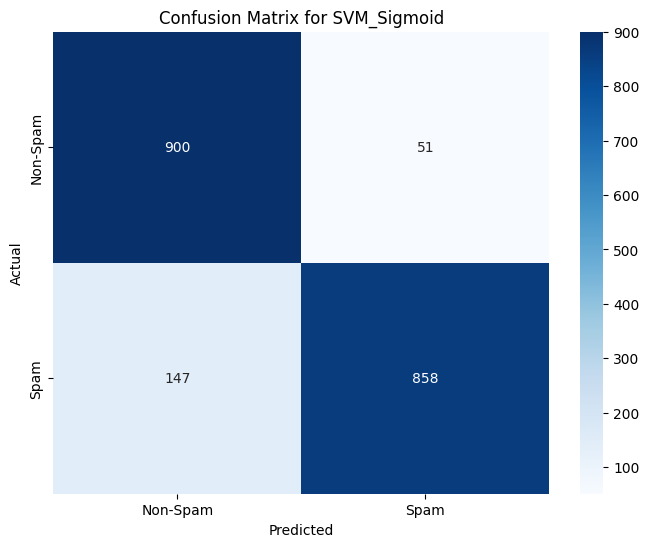

Cross-validation results saved to cross_validation_results.csv


In [57]:
import seaborn as sns
# # Train models and save them
# for model_name, model in models.items():
#     print(f'\nTraining {model_name}...')
#     model.fit(X_train, train_labels)
#     # Save the trained model
#     joblib.dump(model, f'{model_name}_model.pkl')

# # Save the TF-IDF vectorizer
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Cross-validation with predictions for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for model_name, model in models.items():
    print(f'\nTraining and Cross-Validating {model_name}...')
    # Apply cross-validation
    predictions = cross_val_predict(model, X_train, train_labels, cv=cv)
    
    # Evaluate the model
    accuracy = accuracy_score(train_labels, predictions)
    precision = precision_score(train_labels, predictions, average='weighted')
    recall = recall_score(train_labels, predictions, average='weighted')
    f1 = f1_score(train_labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(train_labels, predictions)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
     # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Save the trained model for each test size
    # joblib.dump(model, f'{model_name}_model_test_size_{test_size}.pkl')
    # Train the model on the entire dataset and save it
    model.fit(X_train, train_labels)
    joblib.dump(model, f'{model_name}_model_nonoptmize_.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_nonoptmize_.pkl')

# Save cross-validation results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('cross_validation_results_nonoptmize_testsize0.2.csv', index=False)
print('Cross-validation results saved to cross_validation_results.csv')

In [58]:

# Load and preprocess the testing dataset
test_data_path = '../youtube_comments_i6IOiUi6IYY.xlsx'
test_data = pd.read_excel(test_data_path)
test_texts = test_data['Comment'].apply(text_preprocessing).apply(lemmatize_text)

# Add cleaned comments to the original dataset
test_data['cleaned_comment'] = test_texts

# Save dataset with cleaned comments to CSV
test_data.to_csv('youtube_comments_with_cleaned_nonoptmize_testsize0.2.csv', index=False)
print('Dataset with cleaned comments saved to youtube_comments_with_cleaned_testsize0.2.csv')

# Load the TF-IDF vectorizer and transform the test data
loaded_vectorizer = joblib.load('tfidf_vectorizer_nonoptmize_.pkl')
X_test = loaded_vectorizer.transform(test_texts)

# Load models and make predictions
for model_name in models.keys():
    print(f'\nLoading {model_name} model and making predictions...')
    loaded_model = joblib.load(f'{model_name}_model_nonoptmize_.pkl')
    predictions = loaded_model.predict(X_test)
    test_data[f'{model_name}_Prediction'] = predictions


Dataset with cleaned comments saved to youtube_comments_with_cleaned_testsize0.2.csv

Loading RandomForest model and making predictions...

Loading NaiveBayes model and making predictions...

Loading XGBoost model and making predictions...

Loading SVM_Linear model and making predictions...

Loading SVM_RBF model and making predictions...

Loading SVM_Poly model and making predictions...

Loading SVM_Sigmoid model and making predictions...


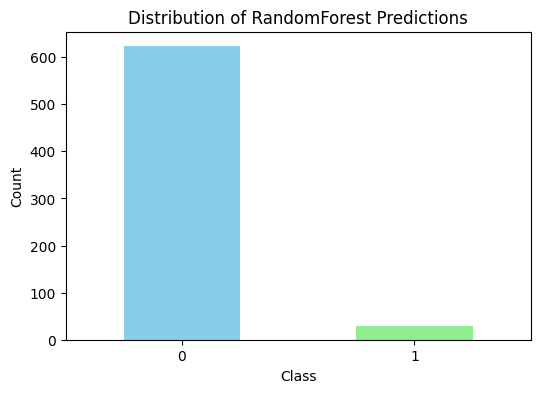

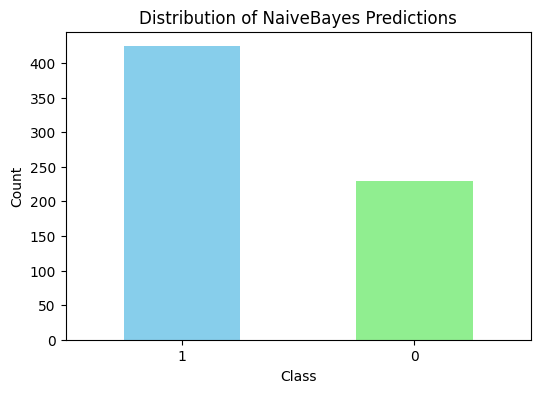

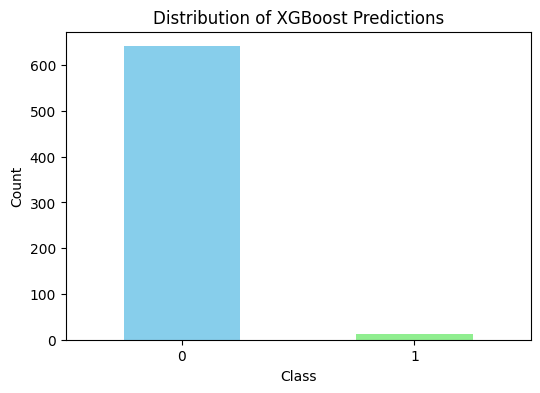

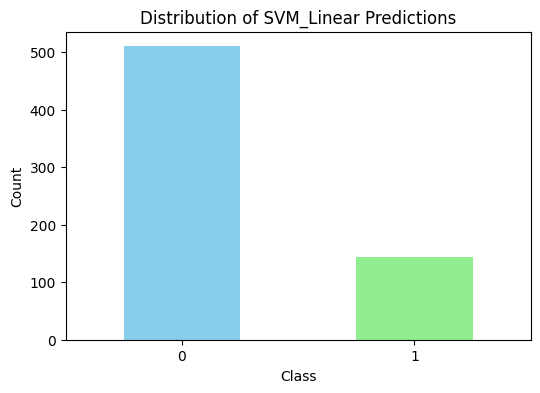

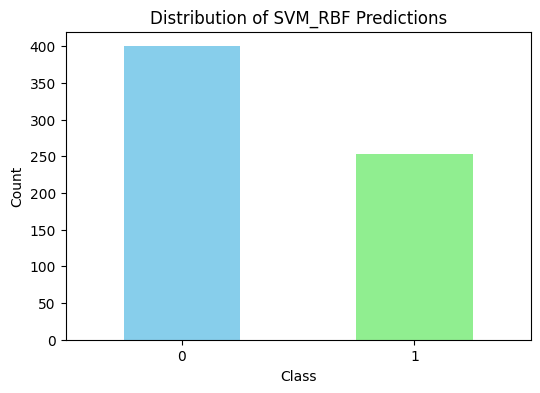

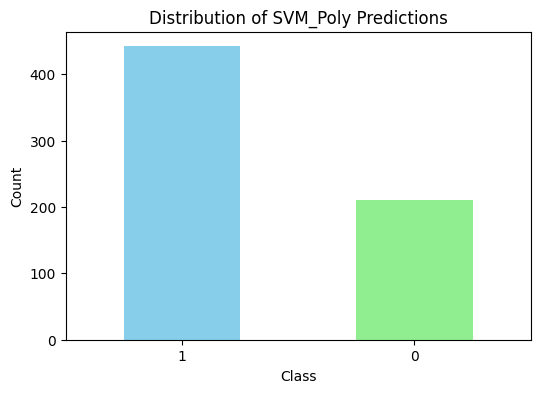

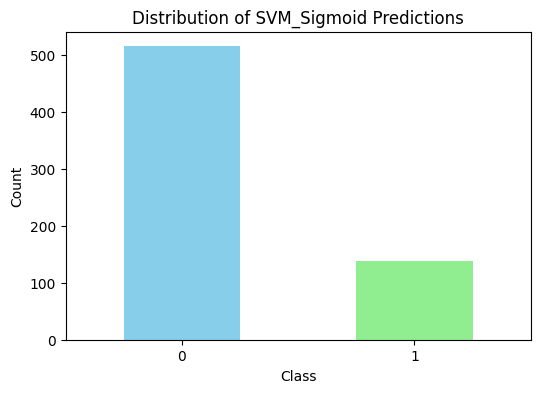

Predictions saved to youtube_comments_predictions_nonoptmize_.xlsx


In [60]:
# Visualize the distribution of predictions for each model
for model_name in models.keys():
    plt.figure(figsize=(6, 4))
    test_data[f'{model_name}_Prediction'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Distribution of {model_name} Predictions')
    plt.xticks(rotation=0)
    plt.show()

# Save the predictions to an Excel file
test_data.to_excel('youtube_comments_predictions_nonoptmize_.xlsx', index=False)
print('Predictions saved to youtube_comments_predictions_nonoptmize_.xlsx')

